# Melanoma Detection

This project is meant to be a test in image processing through a neural net and creates a classification algorithm using the topics covered in the Machine Learning Specialization on Coursera. It uses a dataset from kaggle that can be reached here:
https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection

This model will use greyscale images of different types of skin blemishes to train on.

We first must import the required libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import drive
drive.mount('/content/drive')

### Data Collection

The next portion of this will consist of processing the images into a feature training set. This will also classify each based on the directory they come from. We can change the way the classification works but will classify based on the data it comes from.

In [3]:
def import_data(dir, classifier, dimension):
  Xarr = []
  Yarr = []
  print(f"*** Processing: {dir} ***")
  for path in os.listdir(dir):
      print(f"*** Processing: {path} ***")

      for filename in os.listdir(f"{dir}/{path}"):
          print(f"Processing {path}-{filename}")

          #Open Image and resize
          im =  Image.open(f"{dir}/{path}/{filename}").convert("L")
          resized_im = im.resize(dimension)

          #Append values to arrays
          Xarr.append(list(resized_im.getdata()))
          Yarr.append(classifier[f"{path}"])
          im.close()

  return Xarr, Yarr

In [ ]:
# Initialize some values
image_dimension = (200,200)
features = image_dimension[0]*image_dimension[1]
data_dir = "./drive/MyDrive/ML/Melanoma/skin-lesions"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/valid"
test_dir = f"{data_dir}/test"
class_vals = {
    "nevus": 0,
    "seborrheic_keratosis": 1,
    "melanoma": 2
}


#Import the Data
X_train, Y_train = import_data(train_dir, class_vals, image_dimension)
X_val, Y_val = import_data(val_dir, class_vals, image_dimension)

#Reshape Data
X_train = np.reshape(np.array(X_train), (-1, features))
Y_train = np.reshape(np.array(Y_train), (-1, 1))
X_val = np.reshape(np.array(X_val), (-1, features))
Y_val = np.reshape(np.array(Y_val), (-1, 1))

#Print data shapes
print(f"X shape: {X_train.shape}")
print(f"Y shape: {Y_train.shape}")
print(f"X shape: {X_val.shape}")
print(f"Y shape: {Y_val.shape}")

We need to normalize the data as well, we will use z-score normalization on the data

In [5]:
def zScoreNormilization(X):
    mean = np.mean(X, axis = 0)
    deviation = np.std(X, axis = 0)

    normalized_x = (X - mean)/deviation

    return normalized_x, mean, deviation

X_train, train_mean, train_deviation = zScoreNormilization(X_train)
X_val = (X_val - train_mean)/train_deviation

We also need to shuffle the data so that the model sees different labels throughout its training

In [6]:
p = np.random.permutation(X_train.shape[0])
X_train = X_train[p]
Y_train = Y_train[p]

For analysis we will also run multiple models with varying dataset sizes. We will start at 1 and increase the data set size to create a learning curve so we can see the growth of our model. These will be the size of the training sets we will use:
- 1
- 10
- 50
- 100
- 200
- 400
- 800
- 1000
- 1500
- 2001 (Full set)


In [ ]:
histories=[]
set_size_list = [1, 10, 20, 50, 100, 200, 400, 800, 1000, 1500, 2001]
tf.random.set_seed(1234)
model = tf.keras.Sequential([
    tf.keras.Input(shape = (features,)),
    tf.keras.layers.Dense(units = 25, activation="relu"),
    tf.keras.layers.Dense(units = 15, activation="relu"),
    tf.keras.layers.Dense(units = 7, activation="relu"),
    tf.keras.layers.Dense(units = 3, activation="linear")
])

model.summary()

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)




for i in set_size_list:
  history = model.fit(X_train[:i],Y_train[:i], epochs=50,validation_data=(X_val,Y_val))
  histories.append(history)





# Plotting the Training Accuracy VS the Validation Accuracy

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


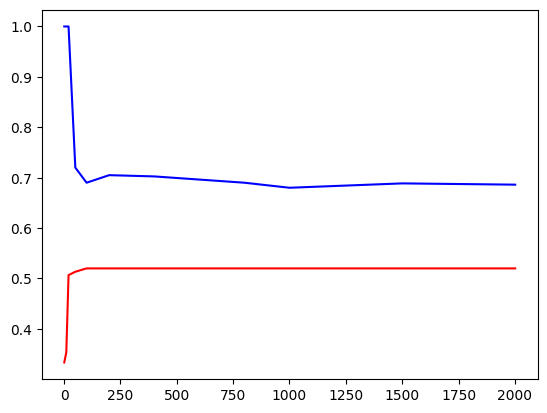

In [18]:
fig, ax = plt.subplots()
ax.plot(set_size_list, [history.history["sparse_categorical_accuracy"][-1] for history in histories], label="Training Loss", color='blue')
ax.plot(set_size_list, [history.history["val_sparse_categorical_accuracy"][-1] for history in histories], label="Validation Loss", color='red')
plt.show()

# Testing the model

In [ ]:
X_test, Y_test = import_data(test_dir, class_vals, image_dimension)
X_test = np.reshape(np.array(X_test), (-1, features))
Y_test = np.reshape(np.array(Y_test), (-1, 1))
X_test = (X_test - train_mean)/train_deviation

predict = model.predict(X_test)


for i in range(predict.shape[0]):
  #predict = (predict > 0.5).astype(int)
  print(f"Actual: {Y_test[i]}, Predicted: {predict[i]}")